<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/HCP_ANN_Connectiviy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 🧠 Compute EC(t) for each subject using NPI.model_ECt
# ============================================

# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
subjects = ["id_100206"]
# or automatically detect all
# subjects = sorted({fn.split("_signals.npy")[0]
#                    for fn in os.listdir(preproc_dir)
#                    if fn.endswith("_signals.npy")})

# --- 6️⃣ Allowlist your model classes (needed for PyTorch ≥2.6) ---
torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

# --- 7️⃣ Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 131 (delta 37), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (131/131), 22.47 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (37/37), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


In [9]:
sig_path = os.path.join(preproc_dir, f"{subjects[0]}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{subjects[0]}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{subjects[0]}_targets.npy")
mdl_path = os.path.join(models_dir,  f"{subjects[0]}_MLP.pt")

In [10]:
Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)

In [13]:
Z.shape

(4680, 450)

In [14]:
FC=np.corrcoef(Z.T)

In [37]:
S=3 #number of steps
N=Z.shape[1] #number of regions
sim = NPI.model_time_series(model, np.zeros((S,N)), tlen=2400, noise_strength=.1)
sim=sim[-400:,:]
sim.shape

(400, 450)

In [38]:
emp=Z[-400:,:]

In [39]:
from scipy import stats

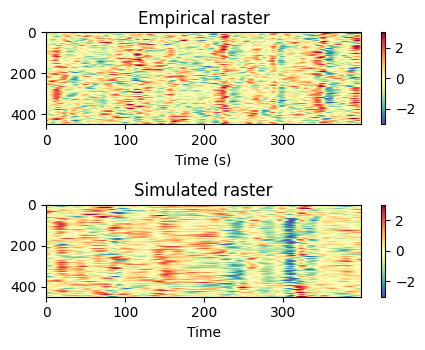

In [40]:
plt.figure(figsize=(4.6,3.6))
plt.subplot(2,1,1)
plt.title('Empirical raster')
plt.imshow(stats.zscore(emp,axis=0)[:,:].T,aspect='auto',vmin=-3,vmax=3,cmap='Spectral_r',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.subplot(2,1,2)
plt.title('Simulated raster')
plt.imshow(stats.zscore(sim,axis=0)[:,:].T,aspect='auto',vmin=-3,vmax=3,cmap='Spectral_r',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
#plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
FC_emp=np.corrcoef(emp.T)
FC_sim=np.corrcoef(sim.T)
FC_emp.shape

(450, 450)

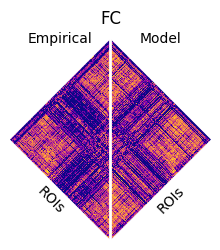

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# FC_emp and FC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = 0, 1

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(FC_emp, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(FC_sim, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'FC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()

In [22]:
EC_t = NPI.model_ECt(model, input_X=X, target_Y=Y, pert_strength=pert_strength)

300.44

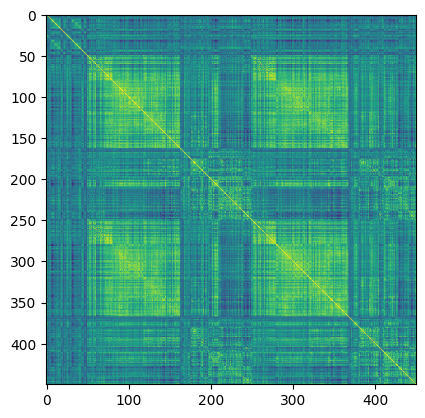

In [8]:
plt.imshow(FC)

In [ ]:
# --- 8️⃣ Main EC(t) extraction loop ---
pert_strength = 0.1
ECts = {}

for sid in subjects:
    print(f"\n================ {sid} ================")

    sig_path = os.path.join(preproc_dir, f"{sid}_signals.npy")
    inp_path = os.path.join(preproc_dir, f"{sid}_inputs.npy")
    tgt_path = os.path.join(preproc_dir, f"{sid}_targets.npy")
    mdl_path = os.path.join(models_dir,  f"{sid}_MLP.pt")

    if not os.path.exists(sig_path) or not os.path.exists(mdl_path):
        print(f"❌ Missing data or model for {sid}")
        continue

    # Load fMRI windows
    Z = np.load(sig_path)             # (T, N)
    X = np.load(inp_path)             # (M, S*N)
    Y = np.load(tgt_path)             # (M, N)

    # Load model
    model = load_model(mdl_path, X, Y)
    print("🧩 Model loaded.")

    # Compute EC(t)
    EC_t = NPI.model_ECt(model, input_X=X, target_Y=Y, pert_strength=pert_strength)
    ECts[sid] = EC_t
    print(f"✅ EC(t) computed: {EC_t.shape}")

    # Save
    out_path = os.path.join(ects_dir, f"{sid}_ECt.npy")
    np.save(out_path, EC_t)
    print(f"💾 Saved EC(t) → {out_path}")

    del Z, X, Y, model, EC_t
    gc.collect(); torch.cuda.empty_cache()

print("\n🎯 All subjects processed successfully.")




notebooks  README.md  src
